# Import thư viện

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import warnings   
warnings.filterwarnings("ignore")

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords

In [ ]:
!pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.0 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [ ]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Price Elasticity

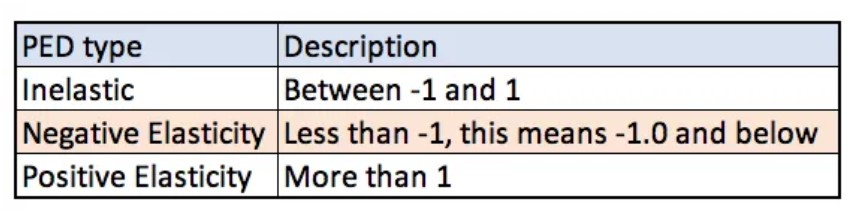

In [ ]:
df = pd.read_excel('/content/[YoRE][KINH TẾ HỌC - TẦM NHÌN BẠN VÀ TÔI 2023][SUPERSTORE].xls', index_col=0)
df['Unit_Price'] = df['Sales']/df['Quantity']
df.head()

,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,...,Region,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit,Unit_Price
Row_ID,,,,,,,,,,,,,,,,,,,,,
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,130.9800
2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,243.9800
3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,7.3100
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,191.5155
5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,11.1840


In [ ]:
category = df['Category'].value_counts()
category

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

## Category: Office Supplies

In [ ]:
df_office = df[df['Category']=='Office Supplies']
df_office = df_office.groupby(['Order_Date','Product_Name']).agg({'Unit_Price':'mean', 'Sales':'mean'}).reset_index()
df_office

,Order_Date,Product_Name,Unit_Price,Sales
0,2014-01-03,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",8.224,16.448
1,2014-01-04,Avery 508,3.928,11.784
2,2014-01-04,GBC Standard Plastic Binding Systems Combs,1.770,3.540
3,2014-01-04,SAFCO Boltless Steel Shelving,90.912,272.736
4,2014-01-05,Avery Hi-Liter EverBold Pen Style Fluorescent ...,6.512,19.536
...,...,...,...,...
5998,2017-12-30,Bagged Rubber Bands,1.008,3.024
5999,2017-12-30,"Cardinal Slant-D Ring Binder, Heavy Gauge Vinyl",6.952,13.904
6000,2017-12-30,Eureka The Boss Plus 12-Amp Hard Box Upright V...,104.650,209.300
6001,2017-12-30,GBC Binding covers,10.360,20.720


In [ ]:
x_pivot = df_office.pivot(index='Order_Date', columns='Product_Name', values='Unit_Price')
x_values = pd.DataFrame(x_pivot.to_records())

In [ ]:
y_pivot = df_office.pivot(index='Order_Date', columns='Product_Name', values='Sales')
y_values = pd.DataFrame(y_pivot.to_records())

In [ ]:
points = []
results_values = {
    "name": [],
    "price_elasticity": [],
    "price_mean": [],
    "quantity_mean": [],
    "intercept": [],
    "t_score":[],
    "slope": [],
    "coefficient_pvalue" : [],
}
#Append x_values with y_values per same product name
for column in x_values.columns[1:]:
    column_points = []
    for i in range(len(x_values[column])):
        if not np.isnan(x_values[column][i]) and not np.isnan(y_values[column][i]):
            column_points.append((x_values[column][i], y_values[column][i]))
    df = pd.DataFrame(list(column_points), columns= ['x_value', 'y_value'])


    #Linear Regression Model
    import statsmodels.api as sm
    x_value = df['x_value']
    y_value = df['y_value']
    X = sm.add_constant(x_value)
    model = sm.OLS(y_value, X)
    result = model.fit()
    
    
    #(Null Hypothesis test) Coefficient with a p value less than 0.05
    if result.f_pvalue < 0.05:
        
        rsquared = result.rsquared
        coefficient_pvalue = result.f_pvalue
        intercept, slope = result.params
        mean_price = np.mean(x_value)
        mean_quantity = np.mean(y_value)
        tintercept, t_score = result.tvalues
     
        #Price elasticity Formula
        price_elasticity = (slope)*(mean_price/mean_quantity)    
            
        #Append results into dictionary for dataframe
        results_values["name"].append(column)
        results_values["price_elasticity"].append(price_elasticity)
        results_values["price_mean"].append(mean_price)
        results_values["quantity_mean"].append(mean_quantity)
        results_values["intercept"].append(intercept)
        results_values['t_score'].append(t_score)
        results_values["slope"].append(slope)
        results_values["coefficient_pvalue"].append(coefficient_pvalue)
        
final_df = pd.DataFrame.from_dict(results_values)
df_elasticity = final_df[['name','price_elasticity','t_score','coefficient_pvalue','slope','price_mean','quantity_mean','intercept']]#,'rsquared']]


In [ ]:
def divergent_plot(df, values_column, ylabel, xlabel):

    #Divergent plot
    df['ranking'] = df[values_column].rank( ascending = True).astype(int)
    df.sort_values(values_column, ascending =False, inplace = True)
    plt.figure(figsize = (12,5), dpi = 80)
    plt.hlines(y = df['ranking'] , xmin = 0, xmax = df[values_column], alpha = 0.5, linewidth = 3)
    
    #Add elasticity labels
    for x, y, tex in zip(df[values_column], df['ranking'] , df[values_column]):
        plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':10})
        
    
    # Axis and title
    plt.gca().set(ylabel= ylabel, xlabel= xlabel)
    plt.yticks(df['ranking'])
    plt.title(values_column , fontdict={'size':13})
    plt.grid(linestyle='--', alpha=0.5)
    plt.show()
            
    
    #Adjust Ranking column and print dataframe
    pd.set_option('display.width', 4000)
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    
    df = df.iloc[:,:3]
    df.set_index('ranking', inplace=True)
    display(df)

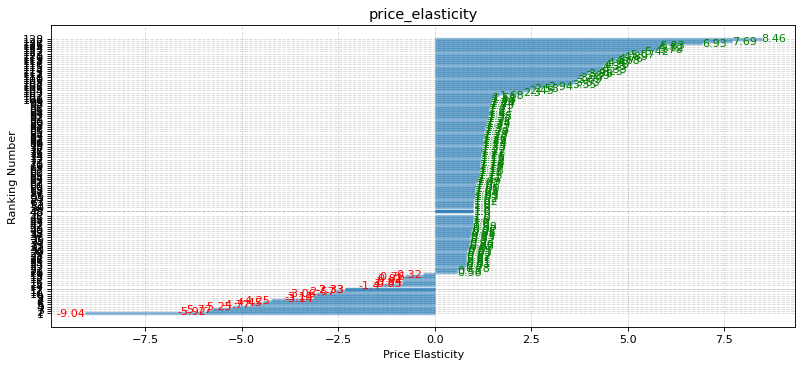

,name,price_elasticity
ranking,,
128,"Adams Telephone Message Books, 5 1/4” x 11”",8.462687
127,Safco Industrial Wire Shelving,7.690141
126,Hunt BOSTON Vista Battery-Operated Pencil Shar...,6.925926
125,Lumber Crayons,5.827586
124,Xerox 1941,5.819277
...,...,...
5,Xerox 1913,-4.769231
4,Mobile Personal File Cube,-5.250000
3,Spiral Phone Message Books with Labels by Adams,-5.766169


In [ ]:
pe_plot = divergent_plot(df_elasticity, 'price_elasticity', 'Ranking Number', 'Price Elasticity')


## Category: Furniture

In [ ]:
df_furniture = df[df['Category']=='Furniture']
df_furniture = df_furniture.groupby(['Order_Date','Product_Name']).agg({'Unit_Price':'mean', 'Sales':'mean'}).reset_index()
df_furniture

,Order_Date,Product_Name,Unit_Price,Sales
0,2014-01-06,Global Deluxe High-Back Manager's Chair,285.980,2573.820
1,2014-01-07,"Howard Miller 14-1/2"" Diameter Chrome Round Wa...",25.576,76.728
2,2014-01-10,"Howard Miller 11-1/2"" Diameter Ridgewood Wall ...",51.940,51.940
3,2014-01-11,"DAX Value U-Channel Document Frames, Easel Back",4.970,9.940
4,2014-01-13,Global Highback Leather Tilter in Burgundy,90.990,545.940
...,...,...,...,...
2104,2017-12-29,"Global Leather and Oak Executive Chair, Black",300.980,300.980
2105,2017-12-29,Hand-Finished Solid Wood Document Frame,34.230,68.460
2106,2017-12-29,Harbour Creations Steel Folding Chair,86.250,258.750
2107,2017-12-29,Nu-Dell Executive Frame,12.640,101.120


In [ ]:
x_pivot = df_furniture.pivot(index='Order_Date', columns='Product_Name', values='Unit_Price')
x_values = pd.DataFrame(x_pivot.to_records())

In [ ]:
y_pivot = df_furniture.pivot(index='Order_Date', columns='Product_Name', values='Sales')
y_values = pd.DataFrame(y_pivot.to_records())

In [ ]:
points = []
results_values = {
    "name": [],
    "price_elasticity": [],
    "price_mean": [],
    "quantity_mean": [],
    "intercept": [],
    "t_score":[],
    "slope": [],
    "coefficient_pvalue" : [],
}
#Append x_values with y_values per same product name
for column in x_values.columns[1:]:
    column_points = []
    for i in range(len(x_values[column])):
        if not np.isnan(x_values[column][i]) and not np.isnan(y_values[column][i]):
            column_points.append((x_values[column][i], y_values[column][i]))
    df = pd.DataFrame(list(column_points), columns= ['x_value', 'y_value'])


    #Linear Regression Model
    import statsmodels.api as sm
    x_value = df['x_value']
    y_value = df['y_value']
    X = sm.add_constant(x_value)
    model = sm.OLS(y_value, X)
    result = model.fit()
    
    
    #(Null Hypothesis test) Coefficient with a p value less than 0.05
    if result.f_pvalue < 0.05:
        
        rsquared = result.rsquared
        coefficient_pvalue = result.f_pvalue
        intercept, slope = result.params
        mean_price = np.mean(x_value)
        mean_quantity = np.mean(y_value)
        tintercept, t_score = result.tvalues
     
        #Price elasticity Formula
        price_elasticity = (slope)*(mean_price/mean_quantity)    
            
        #Append results into dictionary for dataframe
        results_values["name"].append(column)
        results_values["price_elasticity"].append(price_elasticity)
        results_values["price_mean"].append(mean_price)
        results_values["quantity_mean"].append(mean_quantity)
        results_values["intercept"].append(intercept)
        results_values['t_score'].append(t_score)
        results_values["slope"].append(slope)
        results_values["coefficient_pvalue"].append(coefficient_pvalue)
        
final_df = pd.DataFrame.from_dict(results_values)
df_elasticity = final_df[['name','price_elasticity','t_score','coefficient_pvalue','slope','price_mean','quantity_mean','intercept']]#,'rsquared']]


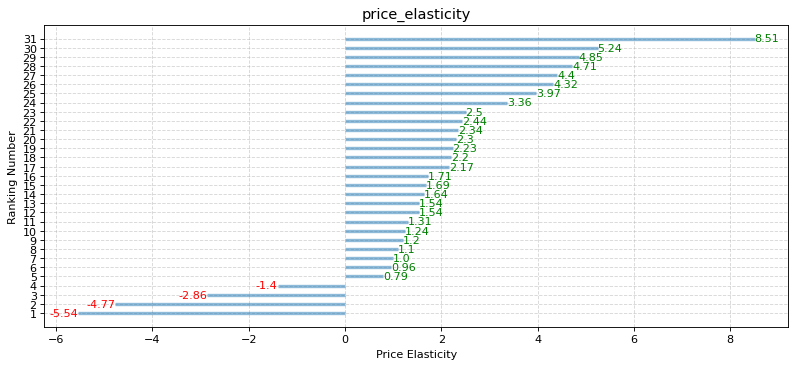

,name,price_elasticity
ranking,,
31,"Leather Task Chair, Black",8.506329
30,Office Star - Contemporary Swivel Chair with P...,5.243286
29,"Global Leather & Oak Executive Chair, Burgundy",4.850446
28,"Computer Room Manger, 14""",4.714286
27,Eldon Radial Chair Mat for Low to Medium Pile ...,4.402062
26,Global Deluxe High-Back Manager's Chair,4.322484
25,Eldon Image Series Black Desk Accessories,3.966102
24,Acrylic Self-Standing Desk Frames,3.363636
23,"Sauder Camden County Collection Libraries, Pla...",2.502866


In [ ]:
pe_plot = divergent_plot(df_elasticity, 'price_elasticity', 'Ranking Number', 'Price Elasticity')

## Category: Technology

In [ ]:
df_technology = df[df['Category']=='Technology']
df_technology = df_technology.groupby(['Order_Date','Product_Name']).agg({'Unit_Price':'mean', 'Sales':'mean'}).reset_index()
df_technology

,Order_Date,Product_Name,Unit_Price,Sales
0,2014-01-06,GE 30524EE4,195.990,391.980
1,2014-01-06,Wireless Extenders zBoost YX545 SOHO Signal Bo...,188.990,755.960
2,2014-01-09,Memorex Micro Travel Drive 8 GB,10.400,31.200
3,2014-01-13,Plantronics S12 Corded Telephone Headset System,107.790,646.740
4,2014-01-15,Logitech 910-002974 M325 Wireless Mouse for We...,29.990,149.950
...,...,...,...,...
1836,2017-12-25,Memorex Micro Travel Drive 4 GB,10.600,31.800
1837,2017-12-27,AT&T 1080 Corded phone,82.194,164.388
1838,2017-12-28,Cush Cases Heavy Duty Rugged Cover Case for Sa...,4.950,14.850
1839,2017-12-29,Adtran 1202752G1,100.792,302.376


In [ ]:
x_pivot = df_technology.pivot(index='Order_Date', columns='Product_Name', values='Unit_Price')
x_values = pd.DataFrame(x_pivot.to_records())

In [ ]:
y_pivot = df_technology.pivot(index='Order_Date', columns='Product_Name', values='Sales')
y_values = pd.DataFrame(y_pivot.to_records())

In [ ]:
points = []
results_values = {
    "name": [],
    "price_elasticity": [],
    "price_mean": [],
    "quantity_mean": [],
    "intercept": [],
    "t_score":[],
    "slope": [],
    "coefficient_pvalue" : [],
}
#Append x_values with y_values per same product name
for column in x_values.columns[1:]:
    column_points = []
    for i in range(len(x_values[column])):
        if not np.isnan(x_values[column][i]) and not np.isnan(y_values[column][i]):
            column_points.append((x_values[column][i], y_values[column][i]))
    df = pd.DataFrame(list(column_points), columns= ['x_value', 'y_value'])


    #Linear Regression Model
    import statsmodels.api as sm
    x_value = df['x_value']
    y_value = df['y_value']
    X = sm.add_constant(x_value)
    model = sm.OLS(y_value, X)
    result = model.fit()
    
    
    #(Null Hypothesis test) Coefficient with a p value less than 0.05
    if result.f_pvalue < 0.05:
        
        rsquared = result.rsquared
        coefficient_pvalue = result.f_pvalue
        intercept, slope = result.params
        mean_price = np.mean(x_value)
        mean_quantity = np.mean(y_value)
        tintercept, t_score = result.tvalues
     
        #Price elasticity Formula
        price_elasticity = (slope)*(mean_price/mean_quantity)    
            
        #Append results into dictionary for dataframe
        results_values["name"].append(column)
        results_values["price_elasticity"].append(price_elasticity)
        results_values["price_mean"].append(mean_price)
        results_values["quantity_mean"].append(mean_quantity)
        results_values["intercept"].append(intercept)
        results_values['t_score'].append(t_score)
        results_values["slope"].append(slope)
        results_values["coefficient_pvalue"].append(coefficient_pvalue)
        
final_df = pd.DataFrame.from_dict(results_values)
df_elasticity = final_df[['name','price_elasticity','t_score','coefficient_pvalue','slope','price_mean','quantity_mean','intercept']]#,'rsquared']]


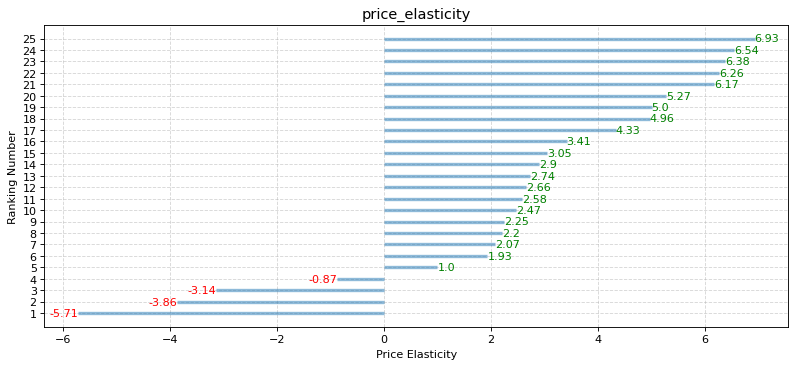

,name,price_elasticity
ranking,,
25,Macally Suction Cup Mount,6.925926
24,Belkin Standard 104 key USB Keyboard,6.538462
23,Adtran 1202752G1,6.379747
22,QVS USB Car Charger 2-Port 2.1Amp for iPod/iPh...,6.263158
21,Apple iPhone 5C,6.174129
20,WD My Passport Ultra 1TB Portable External Har...,5.273973
19,Cisco IP Phone 7961G-GE VoIP phone,5.000000
18,Microsoft Wireless Mobile Mouse 4000,4.963964
17,AT&T SB67148 SynJ,4.333333


In [ ]:
pe_plot = divergent_plot(df_elasticity, 'price_elasticity', 'Ranking Number', 'Price Elasticity')

# Market Basket Analysis

## Xử lý biến text

In [ ]:
df_fp = pd.read_excel('/content/[YoRE][KINH TẾ HỌC - TẦM NHÌN BẠN VÀ TÔI 2023][SUPERSTORE].xls', index_col=0)
df_fp

,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit
Row_ID,,,,,,,,,,,,,,,,,,,,
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,Florida,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028
9991,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332
9992,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932


In [ ]:
df_fp.Product_Name.head(10)

Row_ID
1                     Bush Somerset Collection Bookcase
2     Hon Deluxe Fabric Upholstered Stacking Chairs,...
3     Self-Adhesive Address Labels for Typewriters b...
4         Bretford CR4500 Series Slim Rectangular Table
5                        Eldon Fold 'N Roll Cart System
6     Eldon Expressions Wood and Plastic Desk Access...
7                                            Newell 322
8                        Mitel 5320 IP Phone VoIP phone
9     DXL Angle-View Binders with Locking Rings by S...
10                     Belkin F5C206VTEL 6 Outlet Surge
Name: Product_Name, dtype: object

In [ ]:
# Bỏ dấu chấm, chuyển các chữ cái về dạng viết thường và bỏ các khoảng trắng
df_fp.Product_Name = df_fp.Product_Name.apply(str.lower)
df_fp.Product_Name = df_fp.Product_Name.apply(lambda x: x.replace(".", "").strip())

In [ ]:
# Bỏ các stopword (a, an, and,...), bỏ các dấu và chữ số
df_fp.Product_Name = df_fp.Product_Name.apply(lambda x: remove_stopwords(x).translate(str.maketrans('','',string.punctuation)) .translate(str.maketrans('','',string.digits)))
df_fp.Product_Name.head(10)

Row_ID
1                     bush somerset collection bookcase
2     hon deluxe fabric upholstered stacking chairs ...
3     selfadhesive address labels typewriters universal
4             bretford cr series slim rectangular table
5                                eldon fold n roll cart
6     eldon expressions wood plastic desk accessorie...
7                                               newell 
8                            mitel  ip phone voip phone
9           dxl angleview binders locking rings samsill
10                          belkin fcvtel  outlet surge
Name: Product_Name, dtype: object

## FP-Growth

In [ ]:
order_ids = df_fp.Order_ID.unique()
order_ids

array(['CA-2016-152156', 'CA-2016-138688', 'US-2015-108966', ...,
       'CA-2014-110422', 'CA-2017-121258', 'CA-2017-119914'], dtype=object)

In [ ]:
all_items = []

for val in order_ids:
    general_items = df_fp[df_fp['Order_ID'] == val]['Product_Name'].unique()
    all_items.append(list(general_items))

from functools import reduce

flatten_list = reduce(lambda z, y :z + y, all_items)
flatten_list = set(flatten_list)

fp_growth_df = pd.DataFrame(index=order_ids, columns=flatten_list)
fp_growth_df.fillna(0, inplace=True)
fp_growth_df

,trimflex flexible post binders,rediform sos up phone message bk x bk formpg messagesbk pk,howard miller diameter accuwave ds wall clock,novimex swivel fabric task chair,hon everyday series multitask chairs,lf elite d dazzle designer hard case cover lf stylus pen wiper apple iphone c mini lite,clearone communications chat oc speaker phone,rosewill normal keys usb wired standard keyboard,office star contemporary task swivel chair loop arms charcoal,hoover commercial steamvac,...,longerlife soft white bulbs,xrack file hanging folders,maxell pro minute cdr pack,toshiba iptsd ip telephone,rubbermaid clustermat chairmats mat size x lip x degree angle,canon pc personal laser copier,great white multiuse recycled paper lb bright,jensen smps speaker phone,fellowes personal hanging folder files navy,acco expandable hanging binders
CA-2016-152156,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2016-138688,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
US-2015-108966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2014-115812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2017-114412,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CA-2016-125794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2017-163629,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2014-110422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2017-121258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
for val in order_ids:
    general_items = df_fp[df_fp['Order_ID'] == val]['Product_Name'].unique()
    for item in general_items:
        fp_growth_df.loc[val][item] = 1
fp_growth_df

,trimflex flexible post binders,rediform sos up phone message bk x bk formpg messagesbk pk,howard miller diameter accuwave ds wall clock,novimex swivel fabric task chair,hon everyday series multitask chairs,lf elite d dazzle designer hard case cover lf stylus pen wiper apple iphone c mini lite,clearone communications chat oc speaker phone,rosewill normal keys usb wired standard keyboard,office star contemporary task swivel chair loop arms charcoal,hoover commercial steamvac,...,longerlife soft white bulbs,xrack file hanging folders,maxell pro minute cdr pack,toshiba iptsd ip telephone,rubbermaid clustermat chairmats mat size x lip x degree angle,canon pc personal laser copier,great white multiuse recycled paper lb bright,jensen smps speaker phone,fellowes personal hanging folder files navy,acco expandable hanging binders
CA-2016-152156,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2016-138688,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
US-2015-108966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2014-115812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2017-114412,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CA-2016-125794,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2017-163629,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2014-110422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CA-2017-121258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
res = fpgrowth(fp_growth_df, min_support=0.001, use_colnames=True)
res

/usr/local/lib/python3.9/dist-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.002396,(hon deluxe fabric upholstered stacking chairs...
1,0.001397,(selfadhesive address labels typewriters unive...
2,0.001597,(bretford cr series slim rectangular table)
3,0.050908,(newell )
4,0.001996,(dxl angleview binders locking rings samsill)
...,...,...
691,0.001797,"(avery , newell )"
692,0.001797,"(xerox , staples)"
693,0.001597,"(xerox , staple envelope)"
694,0.001397,"(xerox , hot file pocket floor stand)"


In [ ]:
res.shape

(696, 2)

In [ ]:
res = association_rules(res, metric="lift", min_threshold=1)
res

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(xerox ),(newell ),0.153124,0.050908,0.007986,0.052151,1.024414,0.000190,1.001311
1,(newell ),(xerox ),0.050908,0.153124,0.007986,0.156863,1.024414,0.000190,1.004434
2,(xerox ),(staples),0.153124,0.009183,0.001797,0.011734,1.277734,0.000391,1.002581
3,(staples),(xerox ),0.009183,0.153124,0.001797,0.195652,1.277734,0.000391,1.052872
4,(xerox ),(staple envelope),0.153124,0.009583,0.001597,0.010430,1.088440,0.000130,1.000856
5,(staple envelope),(xerox ),0.009583,0.153124,0.001597,0.166667,1.088440,0.000130,1.016251
6,(xerox ),(hot file pocket floor stand),0.153124,0.002595,0.001397,0.009126,3.516498,0.001000,1.006591
7,(hot file pocket floor stand),(xerox ),0.002595,0.153124,0.001397,0.538462,3.516498,0.001000,1.834897
8,(xerox ),(kingston digital datatraveler gb usb ),0.153124,0.004991,0.001198,0.007823,1.567353,0.000434,1.002854
9,(kingston digital datatraveler gb usb ),(xerox ),0.004991,0.153124,0.001198,0.240000,1.567353,0.000434,1.114310


In [ ]:
res.sort_values("confidence",ascending=Fals
                

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7,(hot file pocket floor stand),(xerox ),0.002595,0.153124,0.001397,0.538462,3.516498,0.001000,1.834897
9,(kingston digital datatraveler gb usb ),(xerox ),0.004991,0.153124,0.001198,0.240000,1.567353,0.000434,1.114310
3,(staples),(xerox ),0.009183,0.153124,0.001797,0.195652,1.277734,0.000391,1.052872
5,(staple envelope),(xerox ),0.009583,0.153124,0.001597,0.166667,1.088440,0.000130,1.016251
1,(newell ),(xerox ),0.050908,0.153124,0.007986,0.156863,1.024414,0.000190,1.004434
0,(xerox ),(newell ),0.153124,0.050908,0.007986,0.052151,1.024414,0.000190,1.001311
2,(xerox ),(staples),0.153124,0.009183,0.001797,0.011734,1.277734,0.000391,1.002581
4,(xerox ),(staple envelope),0.153124,0.009583,0.001597,0.010430,1.088440,0.000130,1.000856
6,(xerox ),(hot file pocket floor stand),0.153124,0.002595,0.001397,0.009126,3.516498,0.001000,1.006591
8,(xerox ),(kingston digital datatraveler gb usb ),0.153124,0.004991,0.001198,0.007823,1.567353,0.000434,1.002854


In [ ]:
res_temp = res[res['confidence']>=0.1]
res_temp = res_temp.sort_values('confidence', ascending = False)
res_temp

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7,(hot file pocket floor stand),(xerox ),0.002595,0.153124,0.001397,0.538462,3.516498,0.001000,1.834897
9,(kingston digital datatraveler gb usb ),(xerox ),0.004991,0.153124,0.001198,0.240000,1.567353,0.000434,1.114310
3,(staples),(xerox ),0.009183,0.153124,0.001797,0.195652,1.277734,0.000391,1.052872
5,(staple envelope),(xerox ),0.009583,0.153124,0.001597,0.166667,1.088440,0.000130,1.016251
1,(newell ),(xerox ),0.050908,0.153124,0.007986,0.156863,1.024414,0.000190,1.004434


In [ ]:
res_temp = res_temp[['antecedents', 'consequents']]

In [ ]:
res_temp.reset_index(drop = True, inplace = True)
res_temp = res_temp.iloc[0:5,]
res_temp

,antecedents,consequents
0,(hot file pocket floor stand),(xerox )
1,(kingston digital datatraveler gb usb ),(xerox )
2,(staples),(xerox )
3,(staple envelope),(xerox )
4,(newell ),(xerox )


In [ ]:
df_condition = df_fp[['Order_ID', 'Product_Name', 'Region', 'Quantity']]
df_condition.reset_index(drop = True, inplace = True)
df_condition

,Order_ID,Product_Name,Region,Quantity
0,CA-2016-152156,bush somerset collection bookcase,South,2
1,CA-2016-152156,hon deluxe fabric upholstered stacking chairs ...,South,3
2,CA-2016-138688,selfadhesive address labels typewriters universal,West,2
3,US-2015-108966,bretford cr series slim rectangular table,South,5
4,US-2015-108966,eldon fold n roll cart,South,2
...,...,...,...,...
9989,CA-2014-110422,ultra door pull handle,South,3
9990,CA-2017-121258,tenex bre series chair mats low pile carpets,West,2
9991,CA-2017-121258,aastra i voip phone,West,2
9992,CA-2017-121258,its hot message books stickers x,West,4


In [ ]:
df_res_1 = df_condition[(df_condition['Product_Name'] == 'xerox') | (df_condition['Product_Name'] == 'hot file pocket floor stand') | (df_condition['Product_Name'] == 'kingston digital datatraveler gb usb ') | (df_condition['Product_Name'] == 'staples') | (df_condition['Product_Name'] == 'staple envelope') | (df_condition['Product_Name'] == 'newell ') ] 
df_res_1

,Order_ID,Product_Name,Region,Quantity
6,CA-2014-115812,newell,West,4
18,CA-2014-143336,newell,West,2
21,CA-2016-137330,newell,Central,7
132,US-2017-164147,staples,East,9
141,CA-2017-106180,newell,West,3
...,...,...,...,...
9791,CA-2014-127166,staple envelope,Central,6
9812,CA-2016-117583,newell,East,3
9818,CA-2015-162201,newell,South,2
9841,US-2016-125402,newell,West,2


In [ ]:
df_fp.Region.unique()

array(['South', 'West', 'Central', 'East'], dtype=object)

In [ ]:
df_res_1 = df_res_1.groupby(by = ['Region'], as_index=False)['Quantity'].sum()
df_res_1

,Region,Quantity
0,Central,382
1,East,425
2,South,283
3,West,428


In [ ]:
def plotting(data, number_des, *args):
  hue_order = ['South', 'West', 'Central', 'East']
  cmap = sns.color_palette("Blues_r", n_colors=4)
  sns.set(font_scale = 2)
  sns.barplot(x = 'Region', y = 'Quantity', hue = "Region", hue_order = hue_order, data = data, order = ['South', 'West', 'Central', 'East'], dodge=False, palette=cmap)
  plt.xlabel('Region', size = 24, weight ='bold')
  plt.ylabel('Quantity', size = 24)
  plt.gcf().set_size_inches(20,18)
  plt.savefig('fpgrowth.png')

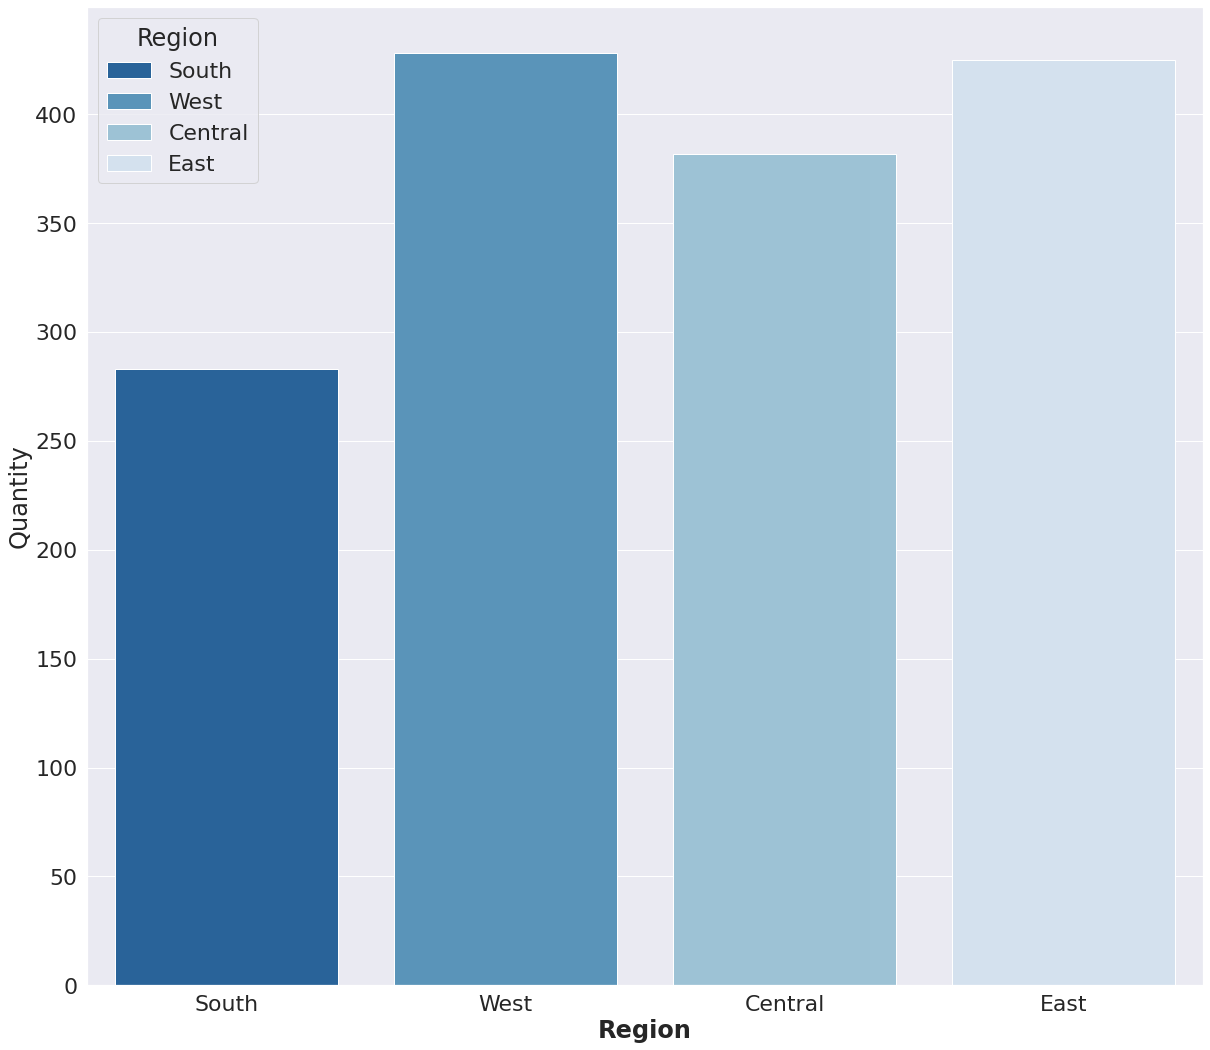

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
plotting(df_res_1, 4, "xerox", "hot file pocket floor stand", "kingston digital datatraveler gb usb ", "staples", "staple envelope", "newell ")

## Apriori

In [ ]:
frequent_itemsets = apriori(fp_growth_df, min_support=0.002, use_colnames=True)
frequent_itemsets

/usr/local/lib/python3.9/dist-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.003194,( diameter round wall clock)
1,0.004392,(memorex micro travel drive gb)
2,0.002396,(bretford rectangular conference table tops)
3,0.002595,(memorex froggy flash drive gb)
4,0.002595,(wilson jones turn tabs binder tool ring binders)
...,...,...
91,0.002795,(eldon wave desk accessories)
92,0.002196,(sterilite officeware hinged file box)
93,0.002196,(poly string tie envelopes)
94,0.007986,"(newell , xerox )"


In [ ]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(newell ),(xerox ),0.050908,0.153124,0.007986,0.156863,1.024414,0.00019,1.004434
1,(xerox ),(newell ),0.153124,0.050908,0.007986,0.052151,1.024414,0.00019,1.001311
